/Users/phinate/code/relaxed/venv/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


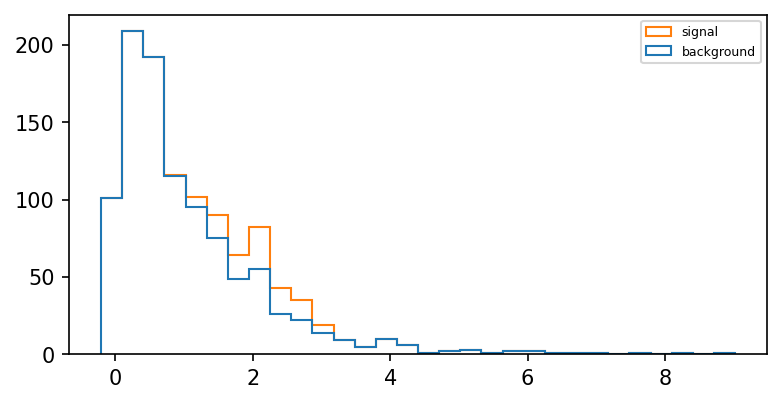

In [1]:
from __future__ import annotations

import jax
import jax.numpy as jnp
from jax.random import PRNGKey
import matplotlib.pyplot as plt
import relaxed
from jaxopt import OptaxSolver
from optax import adam
from functools import partial
import jax.scipy as jsp
from plothelp import autoplot

# matplotlib settings
plt.rc("figure", figsize=(6, 3), dpi=150, facecolor="w")
plt.rc("legend", fontsize=6)

# generate background data from an exponential distribution with a little noise
def generate_background(key, n_samples, n_features, noise_std):
    key, subkey = jax.random.split(key, 2)
    data = jax.random.exponential(subkey, (n_samples, n_features))
    key, subkey = jax.random.split(key, 2)
    data += jax.random.normal(subkey, (n_samples, n_features)) * noise_std
    return data


# generate signal data from a normal distribution close to the background
def generate_signal(key, n_samples, n_features):
    key, subkey = jax.random.split(key, 2)
    data = jax.random.normal(subkey, (n_samples, n_features)) / 2 + 2
    return data


# get 1000 samples from the background and 100 samples from the signal
bkg = generate_background(PRNGKey(0), 1000, 1, 0.1).ravel()
sig = generate_signal(PRNGKey(1), 100, 1).ravel()

plt.hist(
    [bkg, sig], stacked=True, bins=30, histtype="step", label=["background", "signal"]
)
plt.legend();

In [2]:
bins = jnp.linspace(0, 8, 5)


def pipe(bins, s, b, bandwidth=1e-2):
    # restrict bin edges so they don't overlap
    bins_new = jnp.concatenate(
        (
            jnp.array([bins[0]]),
            jnp.where(bins[1:] > bins[:-1], bins[1:], bins[:-1] + 1e-4),
        ),
        axis=0,
    )
    # make differentiable histograms for each dataset
    s_hist = relaxed.hist(s, bins=bins_new, bandwidth=bandwidth) + 1e-4
    b_hist = relaxed.hist(b, bins=bins_new, bandwidth=bandwidth) + 1e-4
    return 1 / relaxed.metrics.asimov_sig(s_hist, b_hist)


def hard_pipe(bins, s, b):
    s_hist = jnp.histogram(s, bins=bins)[0] + 1e-4
    b_hist = jnp.histogram(b, bins=bins)[0] + 1e-4
    return relaxed.metrics.asimov_sig(s_hist, b_hist)

/Users/phinate/code/relaxed/venv/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


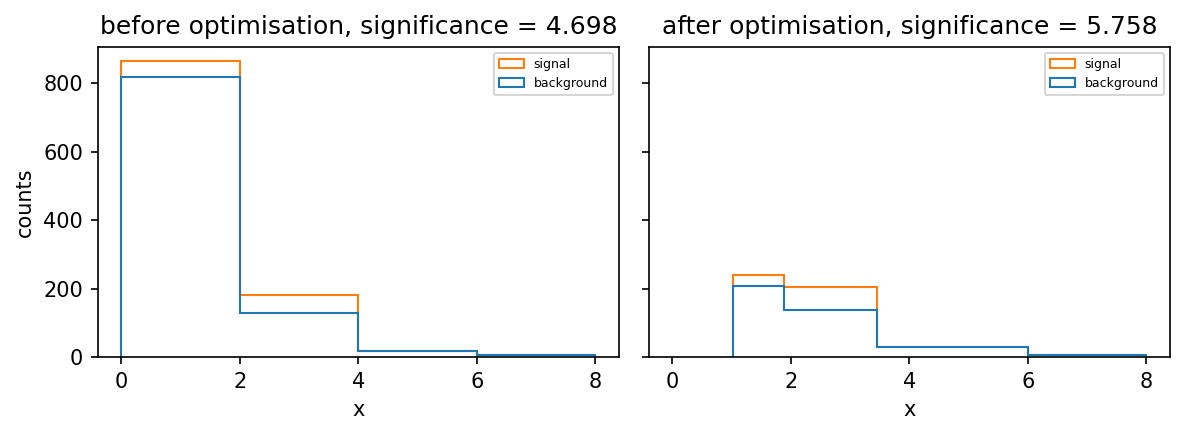

In [3]:
loss = partial(pipe, s=sig, b=bkg, bandwidth=1e-2)
solver = OptaxSolver(loss, adam(learning_rate=1e-2), maxiter=10000, tol=1e-6)
bins_opt = solver.run(bins).params
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
ax = axs[1]
ax.hist(
    [bkg, sig],
    stacked=True,
    bins=bins_opt,
    histtype="step",
    label=["background", "signal"],
)
ax.legend()
ax.set_xlabel("x")
significance = hard_pipe(bins_opt, sig, bkg)
ax.set_title(f"after optimisation, significance = {significance:.3f}")

ax = axs[0]
ax.hist(
    [bkg, sig], stacked=True, bins=bins, histtype="step", label=["background", "signal"]
)
ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("counts")
significance = hard_pipe(bins, sig, bkg)
ax.set_title(f"before optimisation, significance = {significance:.3f}")
plt.tight_layout()

In [13]:
shift = 0.2
bup = bkg + shift
bdown = bkg - shift


def correlated_background(signal, bkg, bkg_up, bkg_down):
    spec = {
        "channels": [
            {
                "name": "single_channel",
                "samples": [
                    {
                        "name": "signal",
                        "data": signal,
                        "modifiers": [
                            {"name": "mu", "type": "normfactor", "data": None}
                        ],
                    },
                    {
                        "name": "background",
                        "data": bkg,
                        "modifiers": [
                            {
                                "name": "correlated_bkg_uncertainty",
                                "type": "histosys",
                                "data": {"hi_data": bkg_up, "lo_data": bkg_down},
                            }
                        ],
                    },
                ],
            }
        ]
    }
    return pyhf.Model(spec, validate=True)


def pipe_uncert(bins, s, b, bandwidth=1e-2):
    # restrict bin edges so they don't overlap
    bins_new = jnp.concatenate(
        (
            jnp.array([bins[0]]),
            jnp.where(bins[1:] > bins[:-1], bins[1:], bins[:-1] + 1e-4),
        ),
        axis=0,
    )
    s_hist = relaxed.hist(s, bins=bins_new, bandwidth=bandwidth) + 1e-4
    b_hist = relaxed.hist(b, bins=bins_new, bandwidth=bandwidth) + 1e-4
    bup_hist = relaxed.hist(bup, bins=bins_new, bandwidth=bandwidth) + 1e-4
    bdown_hist = relaxed.hist(bdown, bins=bins_new, bandwidth=bandwidth) + 1e-4
    uncert = jnp.abs(bup_hist - bdown_hist)
    model = relaxed.dummy_pyhf.uncorrelated_background(s_hist, b_hist, uncert)
    nominal = jnp.array([1.0, 1.0])
    data = model.expected_data(nominal)
    pval = relaxed.infer.hypotest(
        0, lr=1e-3, model=model, data=data, test_stat="q0", expected_pars=nominal
    )
    return pval


def cls_pipe(bins, s, b, bandwidth=1e-2):
    # restrict bin edges so they don't overlap
    bins_new = jnp.concatenate(
        (
            jnp.array([bins[0]]),
            jnp.where(bins[1:] > bins[:-1], bins[1:], bins[:-1] + 1e-4),
        ),
        axis=0,
    )
    s_hist = relaxed.hist(s, bins=bins_new, bandwidth=bandwidth) + 1e-4
    b_hist = relaxed.hist(b, bins=bins_new, bandwidth=bandwidth) + 1e-4
    bup_hist = relaxed.hist(bup, bins=bins_new, bandwidth=bandwidth) + 1e-4
    bdown_hist = relaxed.hist(bdown, bins=bins_new, bandwidth=bandwidth) + 1e-4
    model = pyhf.simplemodels.correlated_background(
        s_hist, b_hist, bup_hist, bdown_hist
    )
    nominal = model.config.suggested_init().at[model.config.poi_index].set(0.0)
    data = model.expected_data(nominal)
    pval = relaxed.infer.hypotest(
        1, lr=1e-3, model=model, data=data, test_stat="q", expected_pars=nominal
    )
    return pval


import pyhf

pyhf.set_backend("jax")


def pipe_uncert_hard(bins, s, b):
    s_hist = jnp.histogram(s, bins=bins)[0] + 1e-4
    b_hist = jnp.histogram(b, bins=bins)[0] + 1e-4
    bup_hist = jnp.histogram(bup, bins=bins)[0] + 1e-4
    bdown_hist = jnp.histogram(bdown, bins=bins)[0] + 1e-4
    uncert = jnp.abs(bup_hist - bdown_hist) + 1e-4
    model = correlated_background(s_hist, b_hist, bup_hist, bdown_hist)
    nominal = model.config.suggested_init()
    data = model.expected_data(nominal)
    pval = pyhf.infer.hypotest(0, pdf=model, data=data, test_stat="q0")
    return jsp.stats.norm.ppf(1 - pval), [s_hist, b_hist, uncert]

In [14]:
# given some 1-D data sig, bkg and variations bkg_up, bkg_down
num_bins = 5
bins = jnp.linspace(0, 8, num_bins + 1)
s_hist = jnp.histogram(sig, bins=bins)[0] + 1e-4 + 10
b_hist = jnp.histogram(bkg, bins=bins)[0] + 1e-4 + 10
bup_hist = jnp.histogram(bup, bins=bins)[0] + 1e-4 + 20
bdown_hist = jnp.histogram(bdown, bins=bins)[0] + 1e-4 + 20
model = correlated_background(s_hist, b_hist, bup_hist, bdown_hist)
nominal = model.config.suggested_init()
data = model.expected_data(nominal)
a = model.logpdf(nominal, data)

# model editing
m = correlated_background(*[jnp.ones(num_bins)] * 4)
m.main_model.nominal_rates = jnp.stack([b_hist, s_hist]).reshape(
    model.main_model.nominal_rates.shape
)
m.main_model.modifiers_appliers["histosys"]._histosys_histoset = [
    [[bdown_hist, b_hist, bup_hist], [s_hist] * 3]
]
b = m.logpdf(nominal, data)
assert a == b

InvalidSpecification: array([33.0001, 87.0001, 10.0001, 10.0001, 10.0001], dtype=float32) is not of type 'array'.
	Path: channels[0].samples[0].data
	Instance: [33.0001 87.0001 10.0001 10.0001 10.0001] Schema: model.json

In [11]:
def pipe(num_bins):
    model = correlated_background(*[jnp.ones(num_bins)] * 4)

    def cls_pipe(bins, s, b, bup, bdown, bandwidth=1e-2):
        # restrict bin edges so they don't overlap
        bins_new = jnp.concatenate(
            (
                jnp.array([bins[0]]),
                jnp.where(bins[1:] > bins[:-1], bins[1:], bins[:-1] + 1e-4),
            ),
            axis=0,
        )
        s_hist = relaxed.hist(s, bins=bins_new, bandwidth=bandwidth) + 1e-4
        b_hist = relaxed.hist(b, bins=bins_new, bandwidth=bandwidth) + 1e-4
        bup_hist = relaxed.hist(bup, bins=bins_new, bandwidth=bandwidth) + 1e-4
        bdown_hist = relaxed.hist(bdown, bins=bins_new, bandwidth=bandwidth) + 1e-4
        model.main_model.nominal_rates = jnp.stack([b_hist, s_hist]).reshape(
            model.main_model.nominal_rates.shape
        )
        model.main_model.modifiers_appliers["histosys"]._histosys_histoset = [
            [[bdown_hist, b_hist, bup_hist], [s_hist] * 3]
        ]
        nominal = (
            jnp.array(model.config.suggested_init()).at[model.config.poi_index].set(0.0)
        )
        data = model.expected_data(nominal)
        pval = relaxed.infer.hypotest(
            1, lr=1e-3, model=model, data=data, test_stat="q", expected_pars=nominal
        )
        return pval

    return cls_pipe


def run(num_bins):
    bins = jnp.linspace(0, 8, num_bins + 1)
    cls_pipe = pipe(num_bins)
    loss = partial(cls_pipe, s=sig, b=bkg, bup=bup, bdown=bdown, bandwidth=1e-1)
    solver = OptaxSolver(loss, adam(learning_rate=1e-3), maxiter=10000, tol=1e-6)
    opt = solver.run(bins).params
    return opt  # , pipe_uncert_hard(opt, sig, bkg)


many = [run(i) for i in range(2, 10)]

/Users/phinate/code/relaxed/venv/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


In [7]:
model.main_model.nominal_rates

DeviceArray([[[[756.00012207, 189.00010681,  40.00009918,  21.00009918,
                 13.00010014]],

              [[ 33.00009918,  87.00009918,  10.00010014,  10.00010014,
                 10.00010014]]]], dtype=float64)

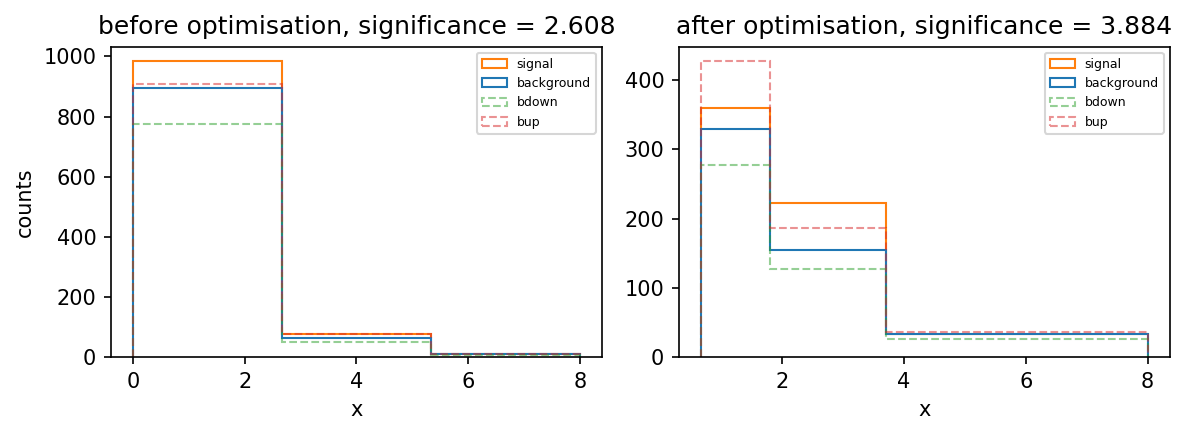

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

ax = axs[1]
ax.hist(
    [bkg, sig],
    stacked=True,
    bins=bins_opt,
    histtype="step",
    label=["background", "signal"],
)

ax.hist(
    bdown.tolist(),
    bins=bins_opt,
    histtype="step",
    label="bdown",
    alpha=0.5,
    linestyle="--",
)
ax.hist(
    bup.tolist(), bins=bins_opt, histtype="step", label="bup", alpha=0.5, linestyle="--"
)
ax.legend()
ax.set_xlabel("x")
significance, yields = pipe_uncert_hard(bins_opt, sig, bkg)
ax.set_title(f"after optimisation, significance = {significance:.3f}")

ax = axs[0]
ax.hist(
    [bkg, sig], stacked=True, bins=bins, histtype="step", label=["background", "signal"]
)
ax.hist(
    bdown.tolist(), bins=bins, histtype="step", label="bdown", alpha=0.5, linestyle="--"
)
ax.hist(
    bup.tolist(), bins=bins, histtype="step", label="bup", alpha=0.5, linestyle="--"
)
ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("counts")
significance, _ = pipe_uncert_hard(bins, sig, bkg)
ax.set_title(f"before optimisation, significance = {significance:.3f}")
plt.tight_layout()

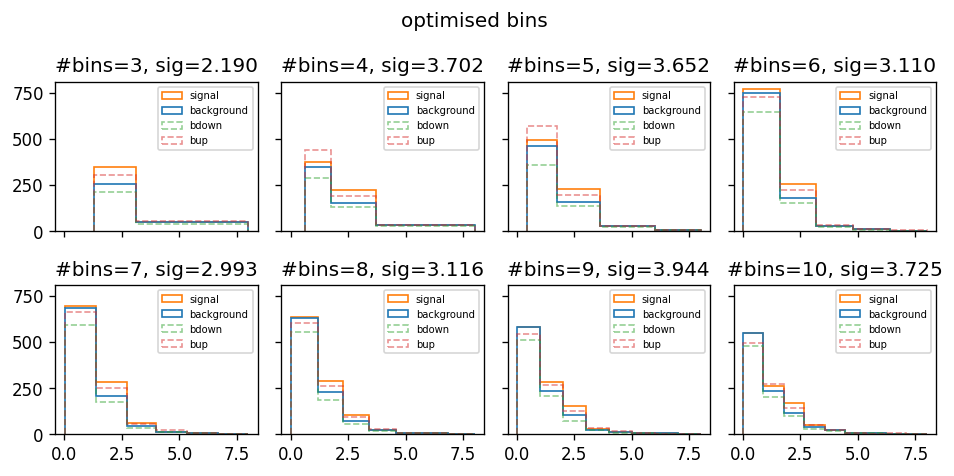

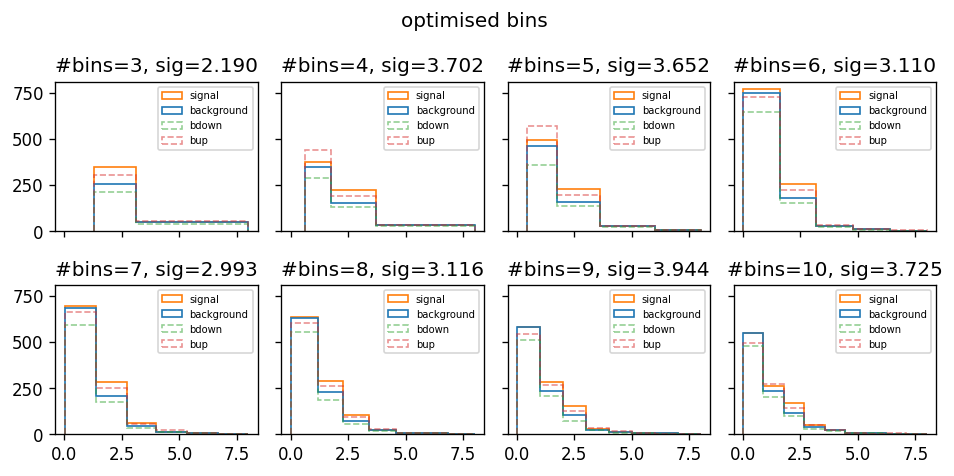

In [12]:
def plot_bins(ax, bins_opt, i) -> None:
    ax.hist(
        [bkg, sig],
        stacked=True,
        bins=bins_opt,
        histtype="step",
        label=["background", "signal"],
    )

    ax.hist(
        bdown.tolist(),
        bins=bins_opt,
        histtype="step",
        label="bdown",
        alpha=0.5,
        linestyle="--",
    )
    ax.hist(
        bup.tolist(),
        bins=bins_opt,
        histtype="step",
        label="bup",
        alpha=0.5,
        linestyle="--",
    )
    ax.legend()
    # ax.set_xlabel("x")
    significance, _ = pipe_uncert_hard(bins_opt, sig, bkg)
    ax.set_title(f"#bins={len(bins_opt)}, sig={significance:.3f}")


autoplot(
    data=many,
    subplot_kwargs={"sharex": True, "sharey": True},
    plot_func=plot_bins,
    title="optimised bins",
    outfile_name="optimised_bins.png",
)